In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
# import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [4]:
import shap
from sklearn.model_selection import train_test_split

X,y = shap.datasets.adult()  # Numerical version of data
X_display, y_display = shap.datasets.adult(display=True)  # Human-readable data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, random_state=10)
clf.fit(X_train.values, y_train)

GradientBoostingClassifier(random_state=10)

In [6]:
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss

# Make predictions on train and test sets
y_train_pred = clf.predict_proba(X_train.values)[:, 1]  # Probabilities for class 1
y_test_pred = clf.predict_proba(X_test.values)[:, 1]

# Calculate zero-one error (classification threshold = 0.5)
train_error = 1 - accuracy_score(y_train, y_train_pred >= 0.5)
test_error = 1 - accuracy_score(y_test, y_test_pred >= 0.5)

# Calculate log-loss
train_logloss = log_loss(y_train, y_train_pred)
test_logloss = log_loss(y_test, y_test_pred)

print("Train set results:")
print(f"Zero-one error: {train_error:.4f}")
print(f"Log-loss: {train_logloss:.4f}")

print("\nTest set results:")
print(f"Zero-one error: {test_error:.4f}")
print(f"Log-loss: {test_logloss:.4f}")

Train set results:
Zero-one error: 0.1315
Log-loss: 0.2878

Test set results:
Zero-one error: 0.1337
Log-loss: 0.2940


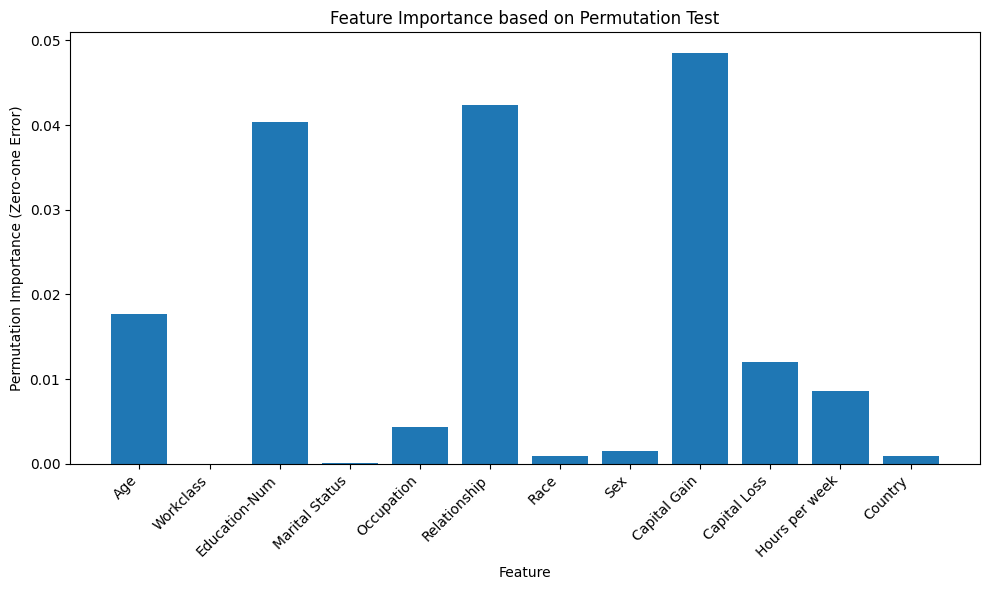

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def permutation_importance(model, X_test, y_test, metric_func):
    """
    Calculates permutation importance for each feature.

    Args:
        model: Trained classification model.
        X_test: Test data.
        y_test: Test labels.
        metric_func: Function to calculate the metric of interest (e.g., zero-one error).

    Returns:
        importances: A list of importance values for each feature.
    """

    baseline_metric = metric_func(y_test, model.predict(X_test))
    importances = []

    for col in range(X_test.shape[1]):
        save_col = X_test[:, col].copy()  # Save the original column
        X_test[:, col] = np.random.permutation(X_test[:, col])  # Permute the column
        permuted_metric = metric_func(y_test, model.predict(X_test))
        importances.append(permuted_metric - baseline_metric)
        X_test[:, col] = save_col  # Restore the original column

    return importances

# Calculate permutation importance based on zero-one error
importances = permutation_importance(clf, X_test.values, y_test,
                                    metric_func=lambda y_true, y_pred: 1 - accuracy_score(y_true, y_pred >= 0.5))

# Visualize with a bar plot
features = X_test.columns
plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance (Zero-one Error)")
plt.title("Feature Importance based on Permutation Test")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

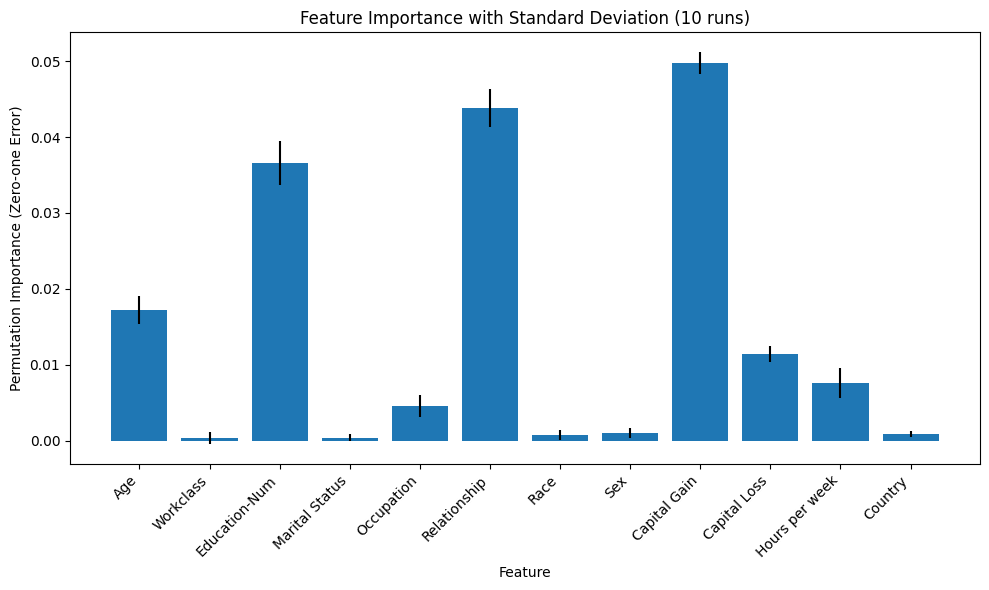

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ... (permutation_importance function from previous code)

num_tests = 10
all_importances = []

for _ in range(num_tests):
    importances = permutation_importance(clf, X_test.values, y_test,
                                        metric_func=lambda y_true, y_pred: 1 - accuracy_score(y_true, y_pred >= 0.5))
    all_importances.append(importances)

mean_importances = np.mean(all_importances, axis=0)
std_importances = np.std(all_importances, axis=0)

# Visualize with bar plot and error bars
plt.figure(figsize=(10, 6))
plt.bar(features, mean_importances, yerr=std_importances)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance (Zero-one Error)")
plt.title("Feature Importance with Standard Deviation (10 runs)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

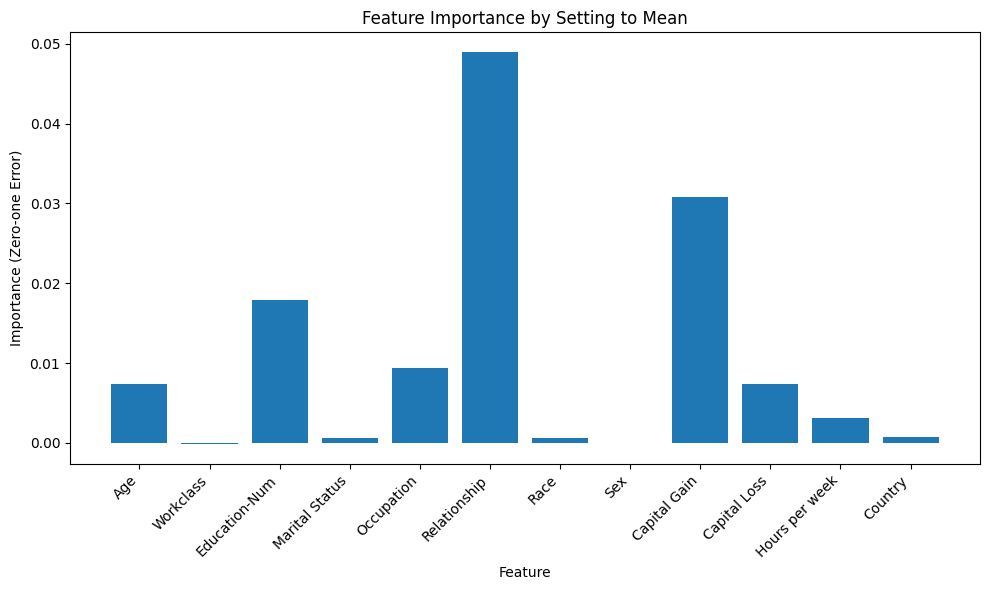

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def mean_importance(model, X_test, y_test, metric_func):
    """
    Calculates feature importance by setting features to their mean.

    Args:
        model: Trained classification model.
        X_test: Test data.
        y_test: Test labels.
        metric_func: Function to calculate the metric of interest.

    Returns:
        importances: A list of importance values for each feature.
    """

    baseline_metric = metric_func(y_test, model.predict(X_test))
    importances = []

    for col in range(X_test.shape[1]):
        save_col = X_test[:, col].copy()  # Save the original column
        X_test[:, col] = X_test[:, col].mean()  # Set values to the mean
        mean_metric = metric_func(y_test, model.predict(X_test))
        importances.append(mean_metric - baseline_metric)
        X_test[:, col] = save_col  # Restore the original column

    return importances

# Calculate mean importance based on zero-one error
importances = mean_importance(clf, X_test.values, y_test,
                             metric_func=lambda y_true, y_pred: 1 - accuracy_score(y_true, y_pred >= 0.5))

# Visualize with a bar plot
plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.xlabel("Feature")
plt.ylabel("Importance (Zero-one Error)")
plt.title("Feature Importance by Setting to Mean")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

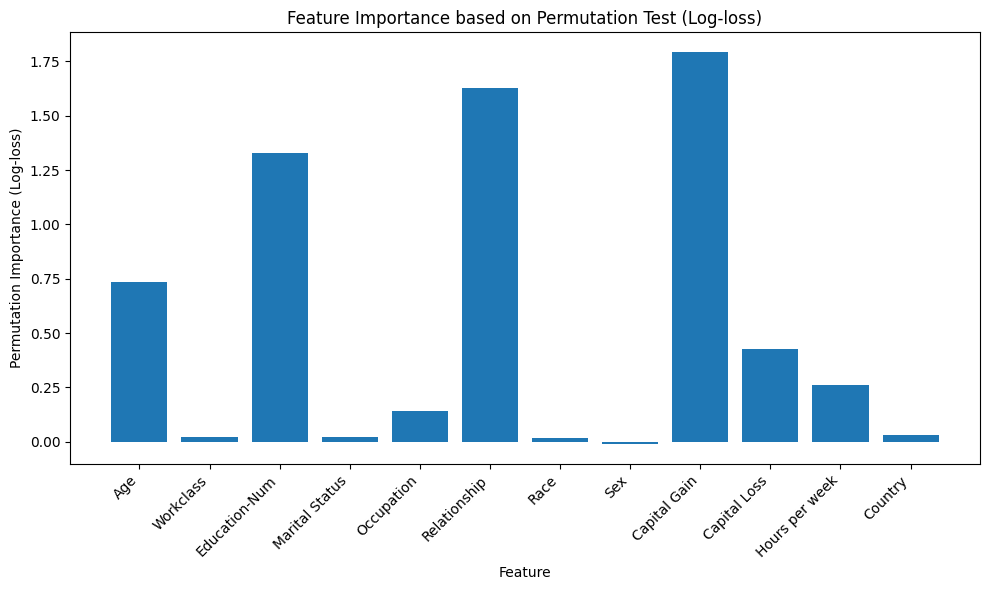

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

# ... (permutation_importance function from previous code)

# Calculate permutation importance based on log-loss
importances = permutation_importance(clf, X_test.values, y_test, metric_func=log_loss)

# Visualize with a bar plot
plt.figure(figsize=(10, 6))
plt.bar(features, importances)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance (Log-loss)")
plt.title("Feature Importance based on Permutation Test (Log-loss)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()